In [1]:
import numpy as np
import collections

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 72)

from gradvi.tests import toy_data
from gradvi.tests import toy_priors
from gradvi.inference import LinearRegression
from gradvi.models import basis_matrix as gvbm
from gradvi.optimize import moving_average as gvma

from mrashpen.utils import R_trendfilter

In [2]:
np.random.seed(100)

#dims = np.power(2, 7 + np.arange(2))
n = 1024
data = dict()
degree = 0
nknots = 20
strue  = 0.2
knots  = np.linspace(0, 1, nknots+2)[1:-1]

# Gamma signal
def sample_sign(n, f = 0.5):
    return np.random.choice([-1, 1], size=n, p=[f, 1 - f])
params = [10, 0.1]
np.random.seed(100)
bfix = np.random.gamma(params[0], params[1], size = nknots + degree)
bfix = np.multiply(bfix, sample_sign(nknots + degree))


x = np.linspace(0, 1, n)
data = toy_data.changepoint_from_bspline(x, knots, strue, degree = degree, 
                signal = "fixed", seed = 100, bfix = bfix,
                include_intercept = False)

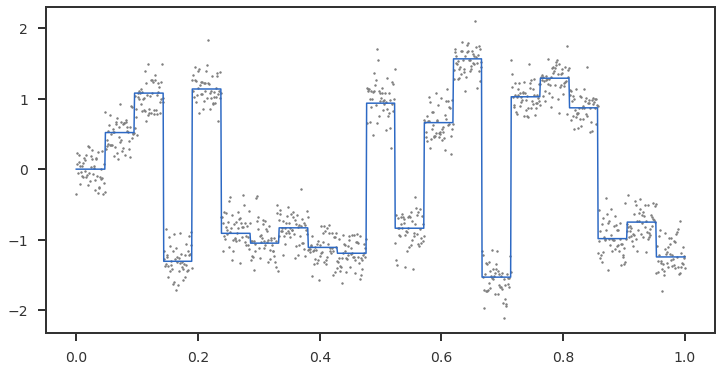

In [3]:
fig = plt.figure(figsize = (12, 6))
ax1 = fig.add_subplot(111)
ax1.scatter(data.x, data.y, s = 2, color = 'grey')
ax1.plot(data.x, data.ytrue)
plt.show()

In [4]:
tf_y, tf_fit = R_trendfilter.fit(data.y, order = degree)
tf_bhat  = np.dot(data.Hinv, tf_y)

R[write to console]: Loading required package: Matrix



Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 



In [5]:
## Genlasso Init

prior_init = toy_priors.get_ash_scaled(k = 20, sparsity = None, skbase = (degree + 1) * 20.0)

yinit = tf_y.copy()
binit = np.dot(data.Hinv, yinit - np.mean(data.y))
s2init = np.var(data.y - yinit) / 10.0

gv01 = LinearRegression(optimize_s = False, optimize_b = False, maxiter = 1000, obj = 'direct', tol = 1e-7)
gv01.fit(data.H, data.y, prior_init, b_init = binit, s2_init = s2init)

In [11]:
## Moving average init

prior_init = toy_priors.get_ash_scaled(k = 20, sparsity = 0.9, skbase = (degree + 1) * 20.0)

yinit = gvma.moving_average(data.y)
binit = np.dot(data.Hinv, yinit - np.mean(data.y))
s2init = np.var(data.y - yinit) / 10.0

gv02 = LinearRegression(optimize_s = False, maxiter = 1000, obj = 'direct', tol = 1e-7)
gv02.fit(data.H, data.y, prior_init, b_init = binit, s2_init = s2init)

In [7]:
gv1 = LinearRegression(obj = 'direct')
gv1.fit(data.H, data.y, gv01.prior, b_init = gv01.coef, s2_init = gv01.residual_var)

In [12]:
gv2 = LinearRegression(obj = 'direct')
gv2.fit(data.H, data.y, gv02.prior, b_init = gv02.coef, s2_init = gv02.residual_var)

In [9]:
ypred_direct_init = np.dot(data.H, gv1.coef) + gv1.intercept
ypred_direct      = np.dot(data.H, gv2.coef) + gv2.intercept

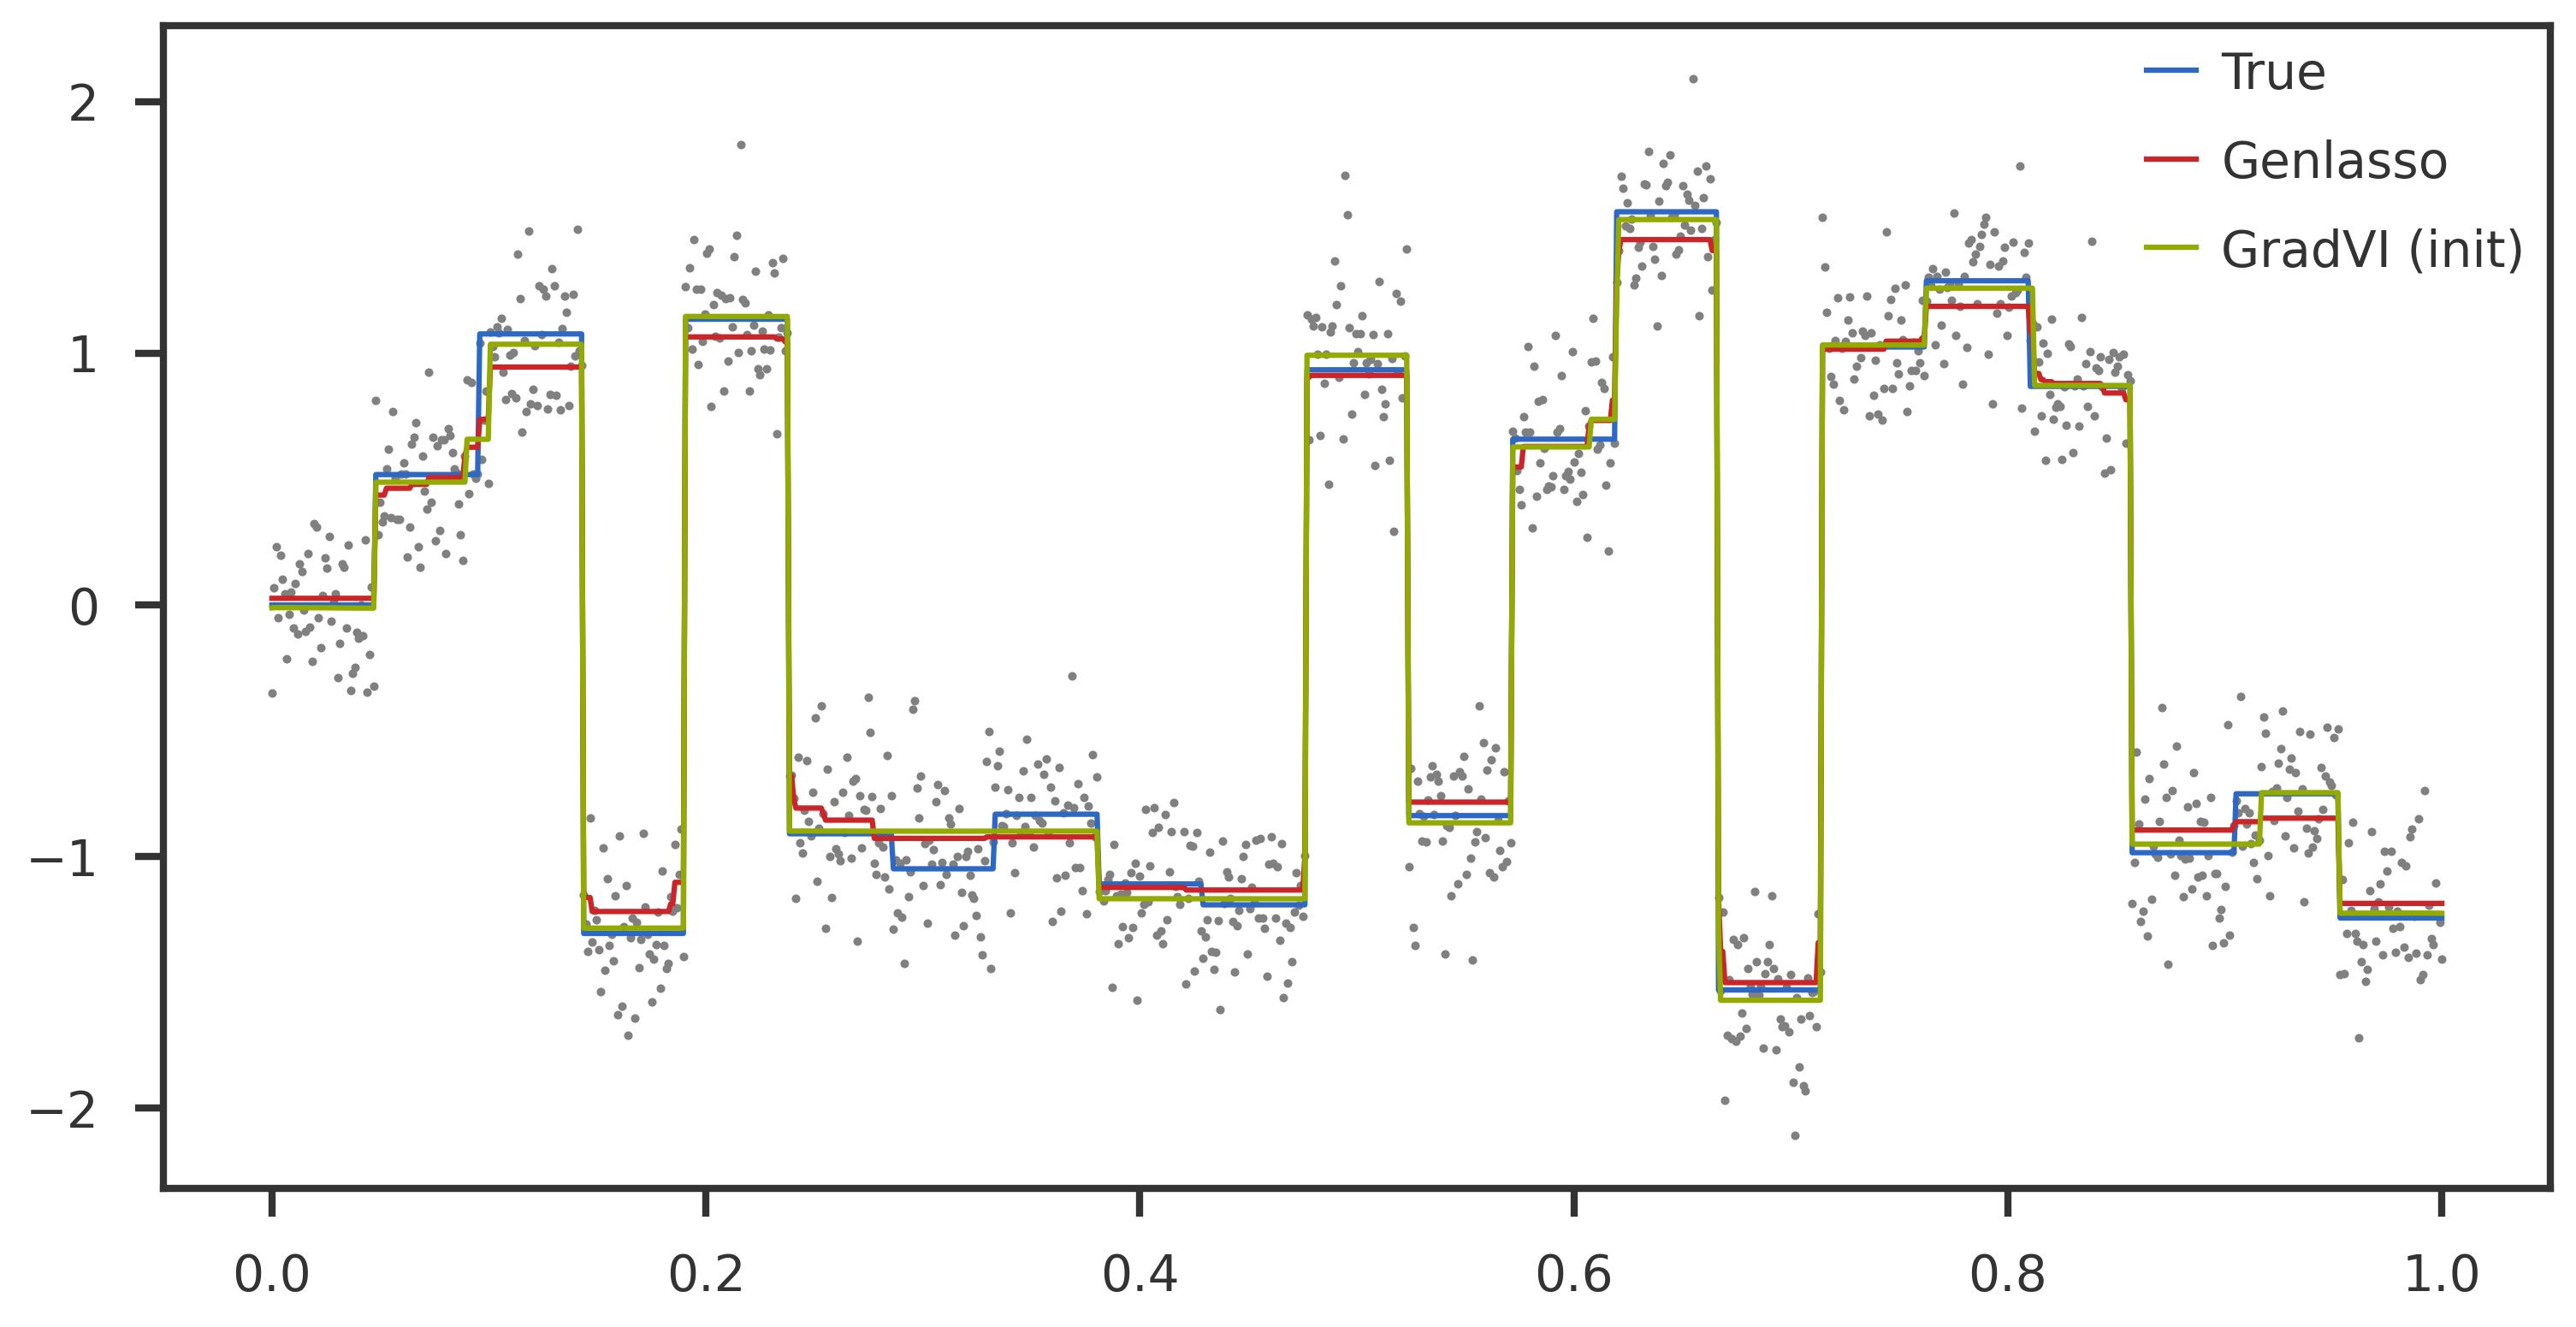

In [16]:
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 300)

fig = plt.figure(figsize = (12, 6))
ax1 = fig.add_subplot(111)
ax1.scatter(data.x, data.y, s = 2, color = 'grey')
ax1.plot(data.x, data.ytrue, label = 'True')
ax1.plot(data.x, tf_y, label = 'Genlasso')
#ax1.plot(data.x, ypred_direct, label = 'GradVI')
ax1.plot(data.x, ypred_direct_init, label = 'GradVI (init)')

ax1.legend()

fig.savefig("trendfiltering_example_gamma.pdf", bbox_inches = 'tight')
plt.show()